In this notebook, we look at the possibilityto detect the signal based only on a fraction of it. We look at the evolution of the SNR and the time at which it is found. Therefore, we subtract the data out of the event and add it by parts. The addition is done from past to future and future to past. The first can be seen as the possibility of an early detection/ The other enables to see if we have the possibility to detect the event based only on a part of the event, which could enable to accelerate the search. 

Here, we do a preleminary search by looking at the GW170814 event.

In [1]:
#make beautiful plots
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [1]:
#libraries
from pycbc.catalog import Merger
import matplotlib.pyplot as plt
import numpy as np
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc import filter
from pycbc.types import Array
from pycbc.waveform import get_td_waveform, get_fd_waveform
from scipy.optimize import minimize
from IPython.display import display, clear_output
from pycbc.filter import matched_filter


First, we need to find the best fit template in order to have a waveform that can be used for the subtraction of the signal and that can then be reinjected into the system in pieces.

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


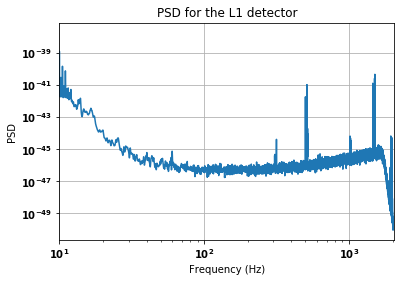

In [3]:
f_low = 20
f_up = 1024

#get raw strain

m = Merger("GW170814")
strain_L1 = m.strain('L1')

#make PSD

psd = strain_L1.psd(4)
psd = interpolate(psd, strain_L1.delta_f)
psd = inverse_spectrum_truncation(psd, 4*strain_L1.sample_rate)

#build white data
white_data = (strain_L1.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30,512).lowpass_fir(300,512)

#plot of the PSD
plt.loglog(psd.delta_f * np.arange(psd.data.size), psd)
plt.xlim(10, 2048)
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("PSD for the L1 detector")
plt.grid()

In [4]:
def gen_template(theta,
                 delta_t=strain_L1.delta_t,
                 duration=strain_L1.duration,
                 start_time=strain_L1.start_time,
                 f_lower=f_low):
    
    """
    Function that enables to generate templates for the event based on 
    the characteristics of the signal that has been provided
    """
    
    m1, m2, distance, inclination, time, phase = theta

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             spin1z=-0.568797,
                             spin2z=0.13079314,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - strain_L1.start_time)
    hp.start_time = strain_L1.start_time

    return hp

In [5]:
#make the timeseries into a frequencyseries
df = strain_L1.to_frequencyseries()

def loglikelihood(theta, df=df, f_lower=f_low, f_upper=f_up):
    """
    Function that computes the loglikelihood for a set of parameters for the
    signal transformed into a frequencyseries
    """
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t=df.delta_t, f_lower=f_low)
    hf = template.to_frequencyseries()
    
    kmin, kmax = filter.get_cutoff_indices(f_low, f_up, df.delta_f, (N - 1) * 2)

    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    logl = -0.5*(hh - 2.0*dh)

    return logl

In [6]:
def whiten_trim_template(template, psd=psd):
    """
    Function that whitens a given template based on the PSD
    """
    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_template = white_template.time_slice(m.time-.2, m.time+.1)
    return white_template

def plot_whitened_strains(strain_L1, template):
    """
    Function that whitens data and that plot it with the template superposed,
    for a zoomed view
    """
    white_data = (strain_L1.to_frequencyseries() / psd**0.5).to_timeseries()

    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    #white_data = white_data.time_slice(m.time-.2, m.time+.1)
    #white_template = white_template.time_slice(m.time-.2, m.time+.1)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.xlim(m.time-.2, m.time+.1)
    plt.ylim(-150, 150)
    plt.legend()
    
def plot_whitened_strains_wide(strain_L1, template):
    """
    Function that whitens data and that plot it with the template superposed,
    for a wide view
    """
    white_data = (strain_L1.to_frequencyseries() / psd**0.5).to_timeseries()

    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    #hite_data = white_data.time_slice(m.time-.2, m.time+.1)
    #white_template = white_template.time_slice(m.time-.2, m.time+.1)

    plt.figure(figsize=[20, 5])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.xlim(m.time-5, m.time+5)
    plt.ylim(-100,100)
    plt.legend()

-71.14832259267033


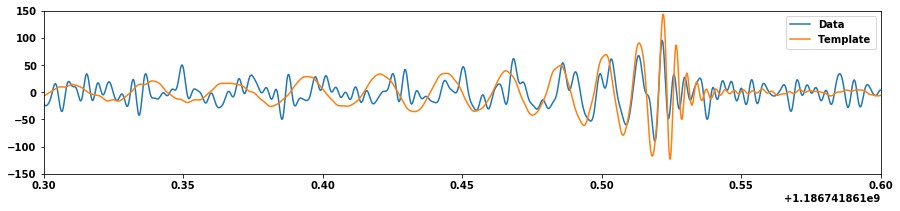

In [7]:
#starting parameters of the analysis
theta0 = [31., 25., 580.,0.6, float(m.time)+0.025,0]

template0 = gen_template(theta0)
plot_whitened_strains(strain_L1, template0)

print(loglikelihood(theta0))

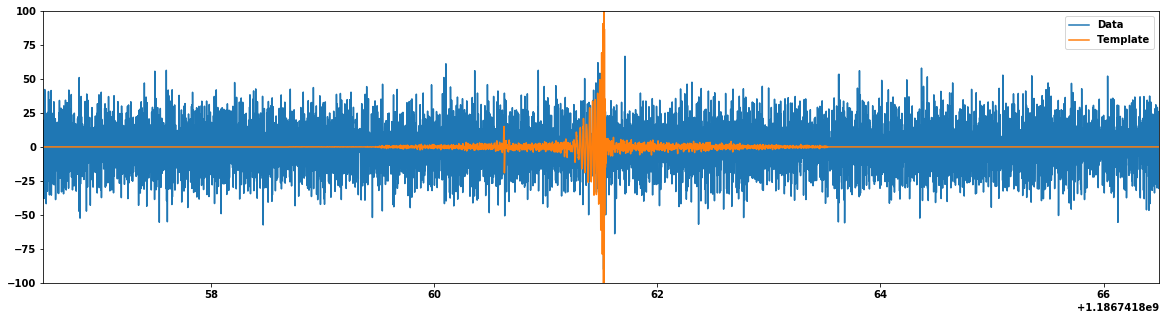

In [8]:
plot_whitened_strains_wide(strain_L1, template0)

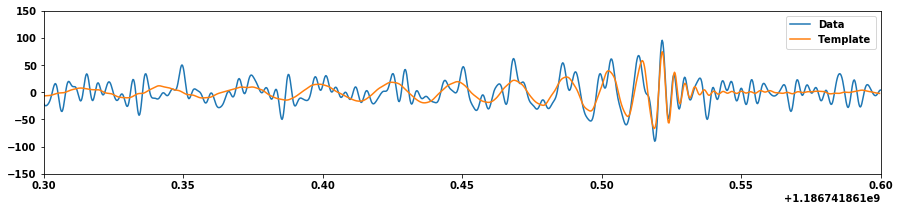

Steps	log(likelihood)
6	85.011


In [9]:
#finding the best fit parameter

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

whitened_template = whiten_trim_template(gen_template(theta0))

plt.plot(white_data.sample_times, white_data, label="Data")
line, = plt.plot(whitened_template.sample_times, whitened_template, label="Template")
plt.ylim(-150, 150)
plt.xlim(m.time-.2, m.time+.1)
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    template = gen_template(thetai)
    white_template = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

Text(0,0.5,'Strain')

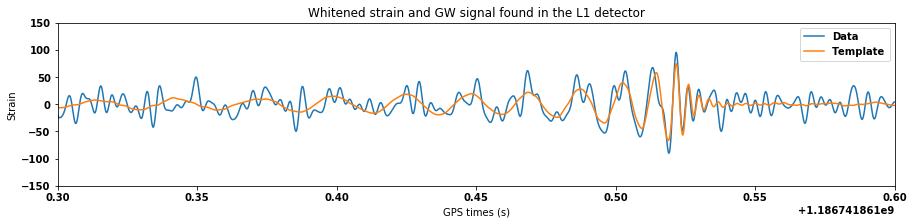

In [10]:
#we axtract the parameters and build the GW signal that is found
best_fit = res.x
signal = gen_template(best_fit)
plot_whitened_strains(strain_L1, signal)
plt.title("Whitened strain and GW signal found in the L1 detector")
plt.xlabel("GPS times (s)")
plt.ylabel("Strain")

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


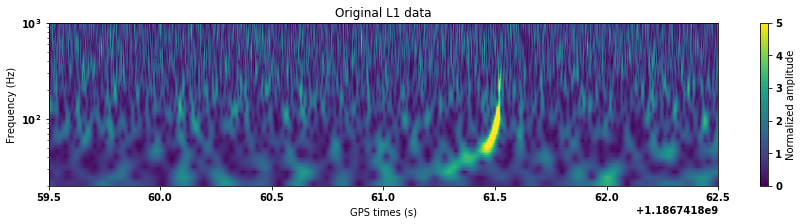

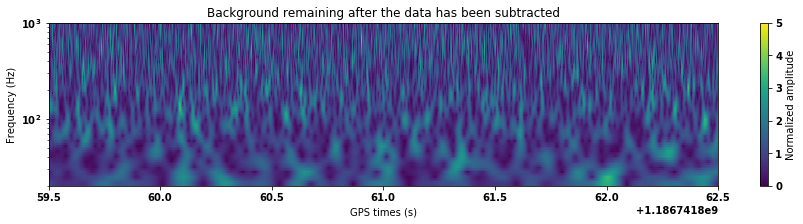

In [11]:
# we build the noise data by removing the signal and build the Qtransform 
# to see if it works well
background = strain_L1 - signal

for dat, title in [(strain_L1, "Original L1 data"),
                  (background, "Background remaining after the data has been subtracted")]:
    t, f, p = dat.whiten(4,4).qtransform(.001, logfsteps = 100, qrange = (8,8),
                                         frange = (20, 1000))
    plt.figure(figsize=[15,3])
    plt.title(title)
    im = plt.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
    plt.yscale('log')
    plt.xlabel('GPS times (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(m.time-2, m.time+1)
    plt.ylim(0,1000)
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Normalized amplitude")

We see that the signal is well extracted here. Now, we need to find a way to fractionate the signal. Therefore, I will first represent it. Indeed, even if we have 32 sec of signal, we know that the signal of a black hole merger is not that long. Therefore, signal that is used is probably zero for a quite substential fraction of time. We can look at the signal and see its characteristics in order to se how we can divide it

In [13]:
#characteristics of the signal
print("Duration: ", signal.duration)
print("Time between consecutive samples: ", signal.delta_t)
print("GPS start and end time: ", signal.start_time, "  ", signal.end_time)

('Duration: ', 32.0)
('Time between consecutive samples: ', 0.000244140625)
('GPS start and end time: ', LIGOTimeGPS(1186741846, 0), '  ', LIGOTimeGPS(1186741878, 0))


Text(0.5,1,'Signal that we want to detect')

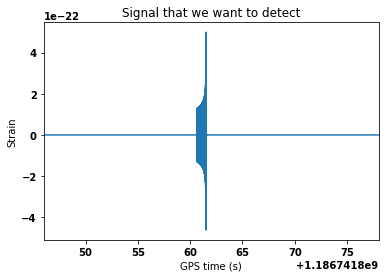

In [14]:
plt.plot(signal.sample_times, signal)
plt.xlim(float(signal.start_time), float(signal.end_time))
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.title("Signal that we want to detect")

when looking at this, one sees that the GW signal that we are looking for is zero for a big part and is non-zero roughly between the 60 and 65 thick. We will only look at the fraction of time in between that part, as it is probably most interesting. First, let's zoom around the time of the event to have a clearer view of the signal there 

Text(0.5,1,'Signal that we want to detect, zoomed around the time of the merger')

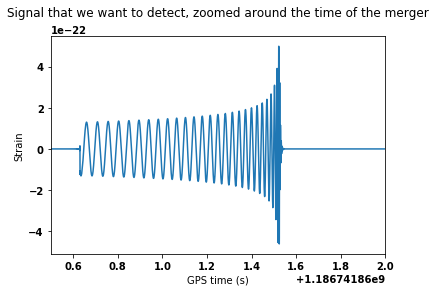

In [15]:
plt.plot(signal.sample_times, signal)
plt.xlim(m.time-1, m.time+0.5)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.title("Signal that we want to detect, zoomed around the time of the merger", pad=20)

Now, we need to find the starting and ending time of the real signal, hence the starting and ending time of the non zero signal.

In [16]:
print("First 10 sample points")
print(signal[0:10])
print("50 sample points around the middle")
print(signal[(int(len(signal)/2)-500):(int(len(signal)/2)-450)])

First 10 sample points
[-4.97049115e-29  4.97138875e-29 -4.97228610e-29  4.97318376e-29
 -4.97408106e-29  4.97497877e-29 -4.97587606e-29  4.97677380e-29
 -4.97767107e-29  4.97856886e-29]
50 sample points around the middle
[ 2.99055812e-27 -2.98996623e-27  2.98937460e-27 -2.98878318e-27
  2.98819202e-27 -2.98760104e-27  2.98701035e-27 -2.98641983e-27
  2.98582961e-27 -2.98523954e-27  2.98464978e-27 -2.98406017e-27
  2.98347087e-27 -2.98288172e-27  2.98229287e-27 -2.98170419e-27
  2.98111579e-27 -2.98052758e-27  2.97993962e-27 -2.97935188e-27
  2.97876437e-27 -2.97817709e-27  2.97759003e-27 -2.97700321e-27
  2.97641660e-27 -2.97583024e-27  2.97524409e-27 -2.97465818e-27
  2.97407249e-27 -2.97348703e-27  2.97290180e-27 -2.97231679e-27
  2.97173201e-27 -2.97114746e-27  2.97056313e-27 -2.96997903e-27
  2.96939516e-27 -2.96881151e-27  2.96822809e-27 -2.96764490e-27
  2.96706191e-27 -2.96647919e-27  2.96589664e-27 -2.96531438e-27
  2.96473227e-27 -2.96415047e-27  2.96356881e-27 -2.96298745e-2

In [17]:
for i in range(len(signal)):
    if signal[i]>10e-26:
        print("Value of the Signal: ", signal[i])
        print("Index of where signal is ample enough: ", i)

('Value of the Signal: ', 1.0035891846326791e-25)
('Index of where signal is ample enough: ', 59777)
('Value of the Signal: ', 1.0168955909887543e-25)
('Index of where signal is ample enough: ', 59779)
('Value of the Signal: ', 1.0305595871047004e-25)
('Index of where signal is ample enough: ', 59781)
('Value of the Signal: ', 1.0445957837786266e-25)
('Index of where signal is ample enough: ', 59783)
('Value of the Signal: ', 1.0590195981418258e-25)
('Index of where signal is ample enough: ', 59785)
('Value of the Signal: ', 1.0738473119728163e-25)
('Index of where signal is ample enough: ', 59787)
('Value of the Signal: ', 1.0890961316435784e-25)
('Index of where signal is ample enough: ', 59789)
('Value of the Signal: ', 1.1047842536395889e-25)
('Index of where signal is ample enough: ', 59791)
('Value of the Signal: ', 1.1209309383625427e-25)
('Index of where signal is ample enough: ', 59793)
('Value of the Signal: ', 1.1375565899959115e-25)
('Index of where signal is ample enough: 

('Index of where signal is ample enough: ', 62454)
('Value of the Signal: ', 1.6148885150229205e-22)
('Index of where signal is ample enough: ', 62455)
('Value of the Signal: ', 1.6336759117584712e-22)
('Index of where signal is ample enough: ', 62456)
('Value of the Signal: ', 1.6488697292466106e-22)
('Index of where signal is ample enough: ', 62457)
('Value of the Signal: ', 1.6609190197372464e-22)
('Index of where signal is ample enough: ', 62458)
('Value of the Signal: ', 1.6693103186211298e-22)
('Index of where signal is ample enough: ', 62459)
('Value of the Signal: ', 1.674506198031584e-22)
('Index of where signal is ample enough: ', 62460)
('Value of the Signal: ', 1.6760076214372215e-22)
('Index of where signal is ample enough: ', 62461)
('Value of the Signal: ', 1.674290929289404e-22)
('Index of where signal is ample enough: ', 62462)
('Value of the Signal: ', 1.6688717029253777e-22)
('Index of where signal is ample enough: ', 62463)
('Value of the Signal: ', 1.66024018407402

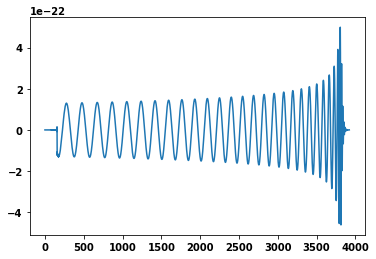

In [18]:
plt.plot(signal[59773:63695])

Text(0.5,0,'GPS time (s)')

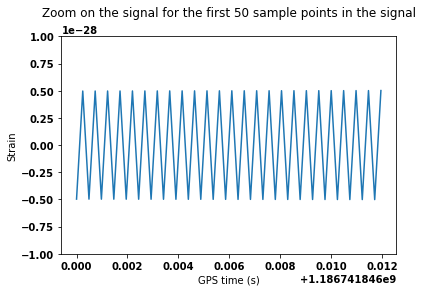

In [19]:
#zoom on the 500 first sample points to see if there is a variation or not
plt.plot(signal[0:50].sample_times, signal[0:50])
plt.ylim(-1*10e-29, 1*10e-29)
plt.title("Zoom on the signal for the first 50 sample points in the signal", pad=20)
plt.ylabel("Strain")
plt.xlabel("GPS time (s)")

We see that the signal is never really zero and that it is already variating at the start. However, we know that the detctor is not sensitive to these variations, as they happen at a far to low frequency. So, we will take the starting and ending points of the merger for the analysis as being the start and end time where the signal is in the senitivity region of the detectors.

For the O2 run, the senitvity at 100Hz was of the order of $8*10^{-24} {strain}/{\sqrt{Hz}}$. Therferefore, we can take the detectable part of the signal to be when the signal has a strain value higher or equal than $10^{-25}$. 

In [20]:
for i in range(len(signal)):
    if signal[i]>=10e-25:
        print("Value of the Signal: ", signal[i])
        print("Index of where signal is ample enough: ", i)

('Value of the Signal: ', 1.0324645590856664e-24)
('Index of where signal is ample enough: ', 59915)
('Value of the Signal: ', 1.192836072268886e-24)
('Index of where signal is ample enough: ', 59917)
('Value of the Signal: ', 1.4120682320955982e-24)
('Index of where signal is ample enough: ', 59919)
('Value of the Signal: ', 1.7297299184101702e-24)
('Index of where signal is ample enough: ', 59921)
('Value of the Signal: ', 2.2308805184091433e-24)
('Index of where signal is ample enough: ', 59923)
('Value of the Signal: ', 3.137012890449037e-24)
('Index of where signal is ample enough: ', 59925)
('Value of the Signal: ', 5.2531552077192646e-24)
('Index of where signal is ample enough: ', 59927)
('Value of the Signal: ', 1.5026450161731117e-23)
('Index of where signal is ample enough: ', 59929)
('Value of the Signal: ', 3.3163967945472096e-24)
('Index of where signal is ample enough: ', 60000)
('Value of the Signal: ', 6.88762783735534e-24)
('Index of where signal is ample enough: ', 6

('Value of the Signal: ', 1.2553356745640015e-22)
('Index of where signal is ample enough: ', 61850)
('Value of the Signal: ', 1.2883877061983406e-22)
('Index of where signal is ample enough: ', 61851)
('Value of the Signal: ', 1.3197735829294192e-22)
('Index of where signal is ample enough: ', 61852)
('Value of the Signal: ', 1.3488052063548775e-22)
('Index of where signal is ample enough: ', 61853)
('Value of the Signal: ', 1.3760731670391619e-22)
('Index of where signal is ample enough: ', 61854)
('Value of the Signal: ', 1.400896310798222e-22)
('Index of where signal is ample enough: ', 61855)
('Value of the Signal: ', 1.4238709952378059e-22)
('Index of where signal is ample enough: ', 61856)
('Value of the Signal: ', 1.4443233019476685e-22)
('Index of where signal is ample enough: ', 61857)
('Value of the Signal: ', 1.4628556302472875e-22)
('Index of where signal is ample enough: ', 61858)
('Value of the Signal: ', 1.4788015493117493e-22)
('Index of where signal is ample enough: '

('Index of where signal is ample enough: ', 63609)
('Value of the Signal: ', 1.104299522349458e-22)
('Index of where signal is ample enough: ', 63610)
('Value of the Signal: ', 8.502510268492021e-23)
('Index of where signal is ample enough: ', 63611)
('Value of the Signal: ', 4.736429918716599e-23)
('Index of where signal is ample enough: ', 63612)
('Value of the Signal: ', 6.151963193084601e-24)
('Index of where signal is ample enough: ', 63613)
('Value of the Signal: ', 1.727372787024969e-23)
('Index of where signal is ample enough: ', 63621)
('Value of the Signal: ', 3.242280952747405e-23)
('Index of where signal is ample enough: ', 63622)
('Value of the Signal: ', 3.9281636489510074e-23)
('Index of where signal is ample enough: ', 63623)
('Value of the Signal: ', 3.7771969518907913e-23)
('Index of where signal is ample enough: ', 63624)
('Value of the Signal: ', 2.934259677129408e-23)
('Index of where signal is ample enough: ', 63625)
('Value of the Signal: ', 1.6603518975166882e-2

The signal that is in the detectable range goes from the index 59915 to 63667

Text(0,0.5,'Strain')

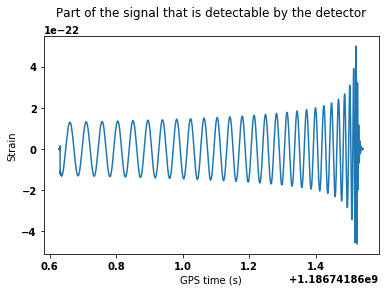

In [21]:
#plot of the signal that can be seen
plt.plot(signal[59915:63667].sample_times, signal[59915:63667])
plt.title("Part of the signal that is detectable by the detector", pad=20)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")

(-1e-24, 1e-24)

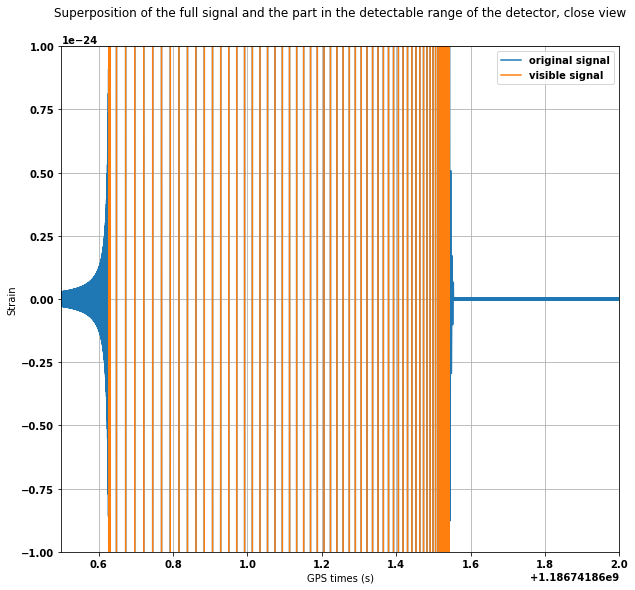

In [22]:
#superposition of the full signal and the signal that is detectable
plt.figure(figsize=[10,9.3])
plt.plot(signal.sample_times, signal, label='original signal')
plt.plot(signal[59915:63667].sample_times, signal[59915:63667], label = 'visible signal')
plt.grid()
plt.legend()
plt.xlabel("GPS times (s)")
plt.ylabel("Strain")
plt.title("Superposition of the full signal and the part in the detectable range of the detector, close view",
         pad=30)
plt.xlim(m.time-1, m.time+0.5)
plt.ylim(-1e-24,1e-24)

(1186741860.5, 1186741862.5)

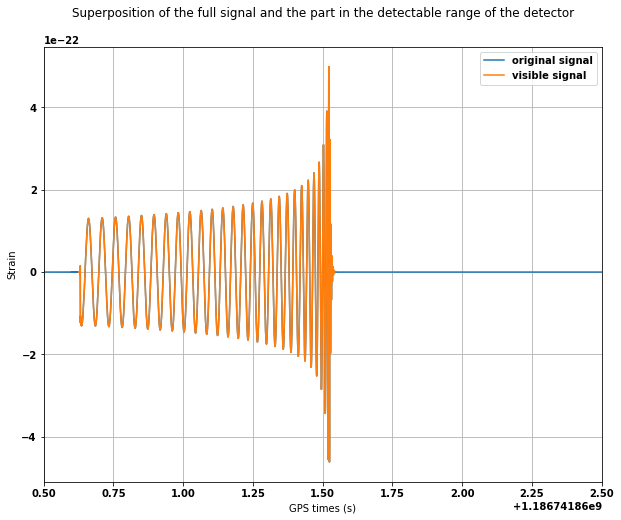

In [23]:
#superposition of the full signal and the signal that is detectable
plt.figure(figsize=[10,8])
plt.plot(signal.sample_times, signal, label='original signal')
plt.plot(signal[59915:63667].sample_times, signal[59915:63667], label = 'visible signal')
plt.grid()
plt.legend()
plt.xlabel("GPS times (s)")
plt.ylabel("Strain")
plt.title("Superposition of the full signal and the part in the detectable range of the detector",
         pad=30)
plt.xlim(m.time-1, m.time+1)
#plt.ylim(-1e-24,1e-24)

In [24]:
#duration of the observable signal
signal[59915]

1.0324645590856664e-24

In [25]:
print(signal.sample_times[59915])

1186741860.6276855


In [26]:
start_ind = 59915
end_ind = 63667
start_vis_sig = signal.sample_times[59915]
end_vis_sig = signal.sample_times[63667]
duration = end_vis_sig - start_vis_sig
vis_sig = signal[59915:63667]
total_ind = 63667-59915
time_step = signal.delta_t
print("The duration of the visible signal is ", duration)
print("the number of samples in the visible signal is ", total_ind)
print("The time step of the signal is ", time_step)

('The duration of the visible signal is ', 0.916015625)
('the number of samples in the visible signal is ', 3752)
('The time step of the signal is ', 0.000244140625)


Now that the signal is well understood, we need to find a way that enables to build the data with slices of the signal

Since the faster method I had thought about does not seem to work.

In [27]:
start_ind = 59915
end_ind = 63667
step = int((end_ind-start_ind) /100)
snrs = []
times = []
snrps = []



for j in range(101):
    to_add = (j+1)*step
    data = strain_L1.copy()
    for i in range((start_ind+to_add), end_ind, 1):
        data[i] = data[i] - signal[i] 
    #build the psd
    psd = strain_L1.psd(4)
    psd = interpolate(psd, strain_L1.delta_f)
    psd = inverse_spectrum_truncation(psd, 4*strain_L1.sample_rate)
    
    #build the template
    hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=strain_L1.delta_f, f_final=739.0645)
    hp.resize(len(psd))
    template = hp.cyclic_time_shift(hp.start_time)
    
    #do the matched filtering
    snr = matched_filter(template, data, psd = psd, low_frequency_cutoff = 15.)
    snr = snr.crop(15,4)
    snrs.append(snr)
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
    snrps.append(snrp)
    times.append(time)
    frac = float(j+1)/100
    print("fraction= %.3f  SNR= %.7f  Time= %.7f" %(frac, abs(snrps[j]), times[j]))
    

fraction= 0.010  SNR= 4.3036514  Time= 1186741869.4284668
fraction= 0.020  SNR= 4.3036428  Time= 1186741869.4284668
fraction= 0.030  SNR= 4.3036413  Time= 1186741869.4284668
fraction= 0.040  SNR= 4.3036301  Time= 1186741869.4284668
fraction= 0.050  SNR= 4.3036244  Time= 1186741869.4284668
fraction= 0.060  SNR= 4.3036212  Time= 1186741869.4284668
fraction= 0.070  SNR= 4.3036093  Time= 1186741869.4284668
fraction= 0.080  SNR= 4.3036064  Time= 1186741869.4284668
fraction= 0.090  SNR= 4.3036003  Time= 1186741869.4284668
fraction= 0.100  SNR= 4.3035896  Time= 1186741869.4284668
fraction= 0.110  SNR= 4.3035885  Time= 1186741869.4284668
fraction= 0.120  SNR= 4.3035793  Time= 1186741869.4284668
fraction= 0.130  SNR= 4.3035718  Time= 1186741869.4284668
fraction= 0.140  SNR= 4.3035706  Time= 1186741869.4284668
fraction= 0.150  SNR= 4.3035596  Time= 1186741869.4284668
fraction= 0.160  SNR= 4.3035564  Time= 1186741869.4284668
fraction= 0.170  SNR= 4.3035531  Time= 1186741869.4284668
fraction= 0.18

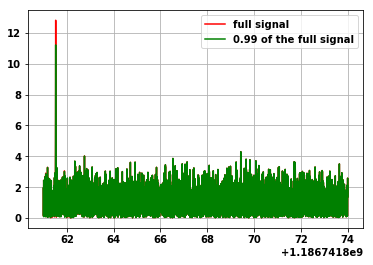

In [28]:
plt.plot(snrs[99].sample_times, abs(snrs[99]), color='red', label = 'full signal')
plt.plot(snrs[98].sample_times, abs(snrs[98]), color = 'green', label='0.99 of the full signal')
plt.legend()
plt.grid()


In [29]:
L_to_R_frac = {}
R_to_L_frac = {}

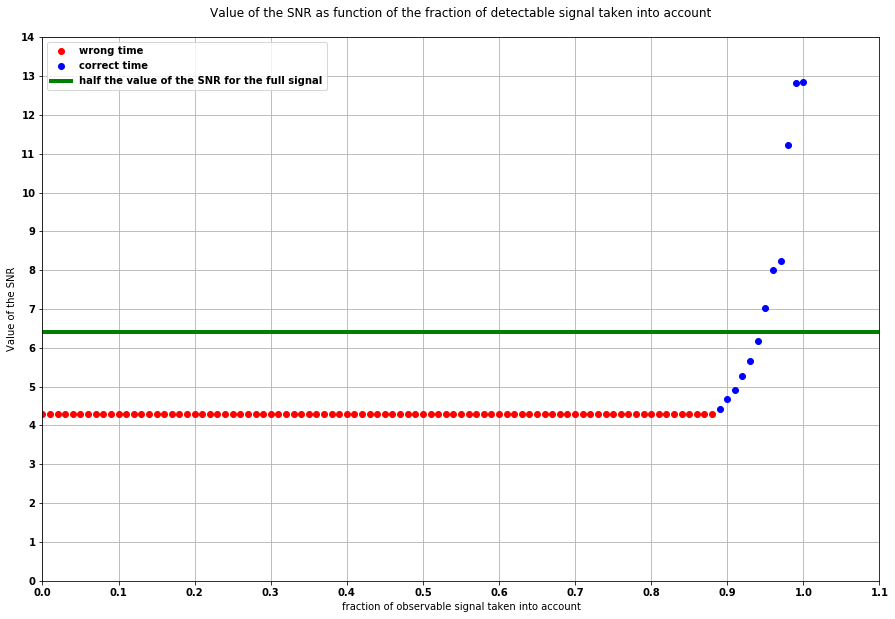

In [30]:
plt.figure(figsize=[15,10])
k = 1
l = 1
for i in range(len(snrps)):
    frac = float(i)/100
    if (times[i] <m.time-1) or (times[i]>m.time+1) :
        if k ==1:
            plt.plot(frac, abs(snrps[i]), 'ro', label = 'wrong time')
            k = k-1
        else:
            wrong = plt.plot(frac, abs(snrps[i]), 'ro')
    else:
        if l == 1:
            L_to_R_frac["GW170814"] = frac
            plt.plot(frac, abs(snrps[i]), 'bo', label='correct time')
            l = l-1
        else:
            correct = plt.plot(frac, abs(snrps[i]), 'bo')
            
plt.grid()
plt.title("Value of the SNR as function of the fraction of detectable signal taken into account", 
              pad = 20)
plt.xlabel("fraction of observable signal taken into account")
plt.ylabel("Value of the SNR")
plt.ylim(0,14)
plt.xticks([0.1*i for i in range(12)])
plt.yticks([i for i in range(15)])
plt.xlim(0,1.1)
plt.axhline(abs(snrps[len(snrps)-1])/2, linewidth = 4, color='green', label='half the value of the SNR for the full signal')
plt.legend(loc='upper left')
    

 We see that when we add the signal from rght to left in time, we need more or less 89% of the signal so that it is detectable and 94% to have a signal that is above half the SNR when we take the full signal into account. Rhese fractions are conservative as we chose the detecable signal below the limit of detectability in this run. However, it shows that the signal can be detected based only on a fraction. A better view of what exatly happens and the constraints needed on the signal can be found by using other thresholds and extrapolate to the limits that are more effective for future (generations of) detectors.

Now, since the information that is incoded in the signal is not homogeneous over time, we can look at how it evolves when we gor from right to left, hence from ring-down to inspiral and see if it makes a big difference

In [31]:
start_ind = 59915
end_ind = 63667
step = int((end_ind-start_ind) /100)
snrs = []
times = []
snrps = []



for j in range(101):
    to_add = (j+1)*step
    data = strain_L1.copy()
    for i in range(start_ind, (end_ind-to_add), 1):
        data[i] = data[i] - signal[i] 
    #build the psd
    psd = strain_L1.psd(4)
    psd = interpolate(psd, strain_L1.delta_f)
    psd = inverse_spectrum_truncation(psd, 4*strain_L1.sample_rate)
    
    #build the template
    hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=strain_L1.delta_f, f_final=739.0645)
    hp.resize(len(psd))
    template = hp.cyclic_time_shift(hp.start_time)
    
    #do the matched filtering
    snr = matched_filter(template, data, psd = psd, low_frequency_cutoff = 15.)
    snr = snr.crop(15,4)
    snrs.append(snr)
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
    snrps.append(snrp)
    times.append(time)
    frac = float(j+1)/100
    print("fraction= %.3f  SNR= %.7f  Time= %.7f" %(frac, abs(snrps[j]), times[j]))
    

fraction= 0.010  SNR= 4.3036581  Time= 1186741869.4284668
fraction= 0.020  SNR= 4.3036583  Time= 1186741869.4284668
fraction= 0.030  SNR= 4.3036644  Time= 1186741869.4284668
fraction= 0.040  SNR= 6.1616626  Time= 1186741861.5241699
fraction= 0.050  SNR= 7.0616149  Time= 1186741861.5241699
fraction= 0.060  SNR= 7.8555848  Time= 1186741861.5241699
fraction= 0.070  SNR= 8.4167756  Time= 1186741861.5241699
fraction= 0.080  SNR= 8.8347192  Time= 1186741861.5241699
fraction= 0.090  SNR= 9.2160004  Time= 1186741861.5244141
fraction= 0.100  SNR= 9.5298645  Time= 1186741861.5244141
fraction= 0.110  SNR= 9.8439520  Time= 1186741861.5244141
fraction= 0.120  SNR= 10.1060059  Time= 1186741861.5244141
fraction= 0.130  SNR= 10.3039066  Time= 1186741861.5244141
fraction= 0.140  SNR= 10.5032413  Time= 1186741861.5244141
fraction= 0.150  SNR= 10.7567069  Time= 1186741861.5244141
fraction= 0.160  SNR= 10.8759721  Time= 1186741861.5244141
fraction= 0.170  SNR= 11.0262310  Time= 1186741861.5244141
fraction

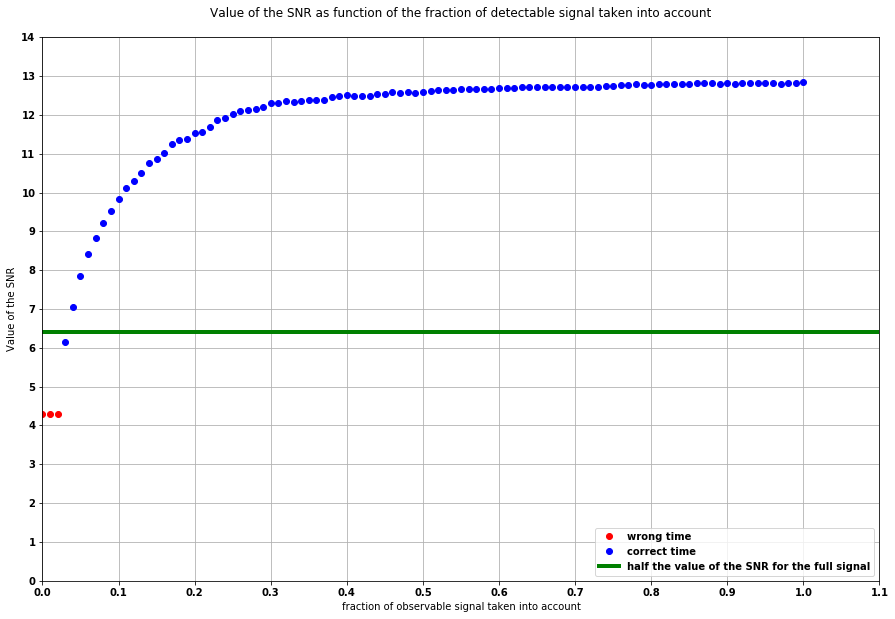

In [32]:
plt.figure(figsize=[15,10])
k = 1
l = 1
for i in range(len(snrps)):
    frac = float(i)/100
    if (times[i] <m.time-0.05) or (times[i]>m.time+0.05) :
        if k ==1:
            plt.plot(frac, abs(snrps[i]), 'ro', label = 'wrong time')
            k = k-1
        else:
            wrong = plt.plot(frac, abs(snrps[i]), 'ro')
    else:
        if l == 1:
            R_to_L_frac['GW170814'] = frac
            plt.plot(frac, abs(snrps[i]), 'bo', label='correct time')
            l = l-1
        else:
            correct = plt.plot(frac, abs(snrps[i]), 'bo')
            
plt.grid()
plt.title("Value of the SNR as function of the fraction of detectable signal taken into account", 
              pad = 20)
plt.xlabel("fraction of observable signal taken into account")
plt.ylabel("Value of the SNR")
plt.ylim(0,14)
plt.xticks([0.1*i for i in range(12)])
plt.yticks([i for i in range(15)])
plt.xlim(0,1.1)
plt.axhline(abs(snrps[len(snrps)-1])/2, linewidth = 4, color='green', label='half the value of the SNR for the full signal')
plt.legend(loc='lower right')
    

We can look at the superposition of the two signals that were included in order to find the SNR at the correct time

In [37]:
stop_LtoR = 90*step
stop_RtoL = 9*step

end_sig_LtoR = start_ind + stop_LtoR
start_sig_RtoL = end_ind - stop_RtoL

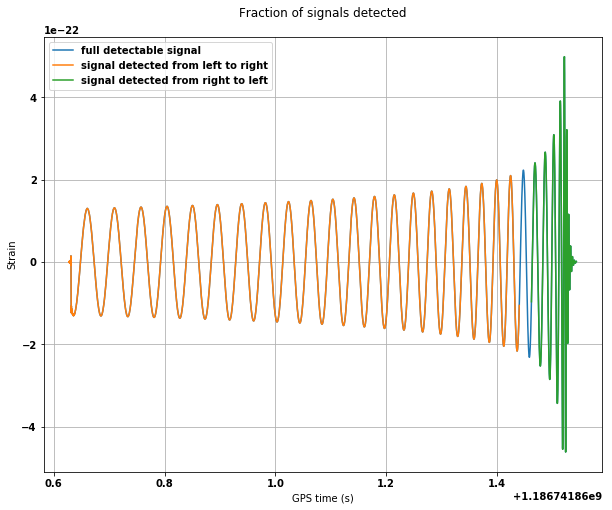

In [40]:
#superposition of the two signal detected (minimal lenght)
plt.figure(figsize = [10,8])
plt.plot(signal[59915:63667].sample_times, signal[59915:63667], label= 'full detectable signal')
plt.plot(signal[59915: end_sig_LtoR].sample_times, signal[59915: end_sig_LtoR], label = 'signal detected from left to right')
plt.plot(signal[start_sig_RtoL:end_ind].sample_times, signal[start_sig_RtoL: end_ind], label = 'signal detected from right to left')
plt.title("Fraction of signals detected", pad=20)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.legend(loc='best')
plt.grid()